In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf

data = pd.read_csv('AAVEUSDT2022-07-10.csv')
data = data.drop(['tickDirection', 'trdMatchID'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.head()

,timestamp,symbol,side,size,price,grossValue,homeNotional,foreignNotional
0,2022-07-10 00:00:12,AAVEUSDT,Buy,7.00,81.8,5.726000e+10,7.00,572.600
1,2022-07-10 00:00:20,AAVEUSDT,Buy,35.20,81.8,2.879360e+11,35.20,2879.360
2,2022-07-10 00:00:20,AAVEUSDT,Buy,7.00,81.8,5.726000e+10,7.00,572.600
3,2022-07-10 00:00:20,AAVEUSDT,Buy,9.79,81.8,8.008220e+10,9.79,800.822
4,2022-07-10 00:00:20,AAVEUSDT,Buy,9.79,81.8,8.008220e+10,9.79,800.822


In [3]:
filter = (data['timestamp'] >= '2022-07-10 00:30:00') & (data['timestamp'] <= '2022-07-10 00:31:00')
data.loc[filter]

,timestamp,symbol,side,size,price,grossValue,homeNotional,foreignNotional
1749,2022-07-10 00:30:07,AAVEUSDT,Sell,0.10,81.55,8.155000e+08,0.10,8.1550
1750,2022-07-10 00:30:07,AAVEUSDT,Sell,0.05,81.55,4.077500e+08,0.05,4.0775
1751,2022-07-10 00:30:09,AAVEUSDT,Sell,0.06,81.50,4.890000e+08,0.06,4.8900
1752,2022-07-10 00:30:09,AAVEUSDT,Buy,5.49,81.50,4.474350e+10,5.49,447.4350
1753,2022-07-10 00:30:10,AAVEUSDT,Buy,7.00,81.50,5.705000e+10,7.00,570.5000
1754,2022-07-10 00:30:11,AAVEUSDT,Sell,0.50,81.50,4.075000e+09,0.50,40.7500
1755,2022-07-10 00:30:15,AAVEUSDT,Sell,20.00,81.50,1.630000e+11,20.00,1630.0000
1756,2022-07-10 00:30:17,AAVEUSDT,Buy,7.50,81.55,6.116250e+10,7.50,611.6250
1757,2022-07-10 00:30:27,AAVEUSDT,Sell,5.00,81.55,4.077500e+10,5.00,407.7500
1758,2022-07-10 00:30:31,AAVEUSDT,Buy,8.50,81.60,6.936000e+10,8.50,693.6000


In [4]:
minutly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='min')]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
minutly_price.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-10 00:00:00,81.80,81.95,81.80,81.80,430.50
2022-07-10 00:01:00,81.85,82.10,81.80,82.00,1642.93
2022-07-10 00:02:00,82.05,82.10,81.85,81.95,249.23
2022-07-10 00:03:00,82.00,82.05,81.95,82.00,78.82
2022-07-10 00:04:00,82.00,82.00,81.80,81.85,631.03


In [5]:
minutly_price.columns.tolist()

['Open', 'High', 'Low', 'Close', 'Volume']

c:\Users\daria\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


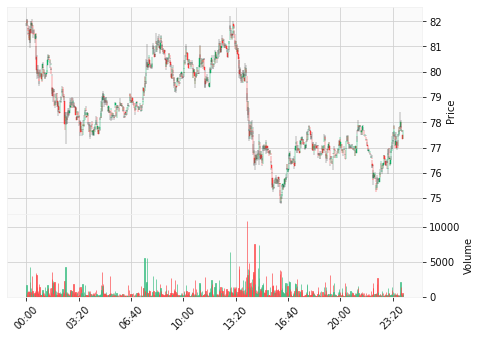

In [6]:
mpf.plot(minutly_price,style='yahoo', type='candle', volume=True)

In [7]:
minutly_price.rename(columns = {'timestamp' : 'Timestamp'}, inplace = True)

minutly_price.head()
#minutly_price.reset_index()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-10 00:00:00,81.80,81.95,81.80,81.80,430.50
2022-07-10 00:01:00,81.85,82.10,81.80,82.00,1642.93
2022-07-10 00:02:00,82.05,82.10,81.85,81.95,249.23
2022-07-10 00:03:00,82.00,82.05,81.95,82.00,78.82
2022-07-10 00:04:00,82.00,82.00,81.80,81.85,631.03


In [8]:
fig = go.Figure(data=[go.Candlestick(
                x=minutly_price.index.to_list(),
                open=minutly_price['Open'],
                high=minutly_price['High'],
                low=minutly_price['Low'],
                close=minutly_price['Close'])])

fig.show()

In [9]:
hourly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='H')]).agg(
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Open = ('price', 'first'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
hourly_price.head(24)

,High,Low,Open,Close,Volume
timestamp,,,,,
2022-07-10 00:00:00,82.10,79.45,81.80,79.60,43072.77
2022-07-10 01:00:00,80.70,78.55,79.65,78.65,43319.46
2022-07-10 02:00:00,79.45,77.15,78.65,78.85,31518.30
2022-07-10 03:00:00,78.90,77.45,78.80,77.85,23232.52
2022-07-10 04:00:00,79.25,77.35,77.80,78.90,26194.27
2022-07-10 05:00:00,79.00,78.05,78.85,78.70,15846.35
2022-07-10 06:00:00,79.15,78.15,78.70,78.60,10415.79
2022-07-10 07:00:00,81.10,78.40,78.60,80.25,33342.11
2022-07-10 08:00:00,81.55,80.05,80.20,80.50,29152.15


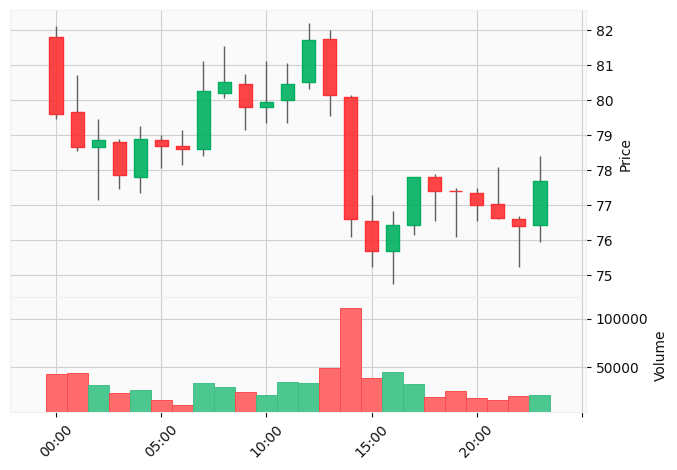

In [10]:
mpf.plot(hourly_price,style='yahoo', type='candle', volume=True)

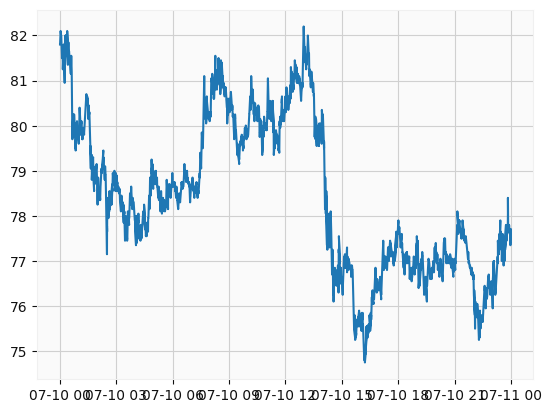

In [11]:
plt.plot(data.timestamp, data.price)

In [20]:
data.sort_values(by = ["timestamp", "price"])

,timestamp,symbol,side,size,price,grossValue,homeNotional,foreignNotional
0,2022-07-10 00:00:12,AAVEUSDT,Buy,7.00,81.80,5.726000e+10,7.00,572.600
1,2022-07-10 00:00:20,AAVEUSDT,Buy,35.20,81.80,2.879360e+11,35.20,2879.360
2,2022-07-10 00:00:20,AAVEUSDT,Buy,7.00,81.80,5.726000e+10,7.00,572.600
3,2022-07-10 00:00:20,AAVEUSDT,Buy,9.79,81.80,8.008220e+10,9.79,800.822
4,2022-07-10 00:00:20,AAVEUSDT,Buy,9.79,81.80,8.008220e+10,9.79,800.822
...,...,...,...,...,...,...,...,...
60003,2022-07-10 23:59:57,AAVEUSDT,Buy,1.30,77.65,1.009450e+10,1.30,100.945
60004,2022-07-10 23:59:57,AAVEUSDT,Buy,1.30,77.65,1.009450e+10,1.30,100.945
60005,2022-07-10 23:59:57,AAVEUSDT,Buy,26.52,77.65,2.059278e+11,26.52,2059.278
60006,2022-07-10 23:59:57,AAVEUSDT,Buy,1.30,77.70,1.010100e+10,1.30,101.010
